<a href="https://colab.research.google.com/github/RNy7846/Classificacao_pneumonia/blob/main/DenseNet_Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Instalando visualkeras

In [ ]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Importando Bibliotecas

In [ ]:
import os
import cv2
import pathlib
import visualkeras

import numpy as np
import scipy as sc
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.initializers import GlorotNormal
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG

print("Versão do TensorFlow:", tf.__version__)

Versão do TensorFlow: 2.12.0


In [ ]:
BATCH_SIZE = 32
EPOCHS = 100

TRAIN_PATH = '/content/drive/MyDrive/Colab Notebooks/Trabalho da Raquel/chest_xray/train'
TEST_PATH = '/content/drive/MyDrive/Colab Notebooks/Trabalho da Raquel/chest_xray/test'

TRAIN_NORMAL = os.listdir(TRAIN_PATH + '/NORMAL')
TRAIN_PNEUMONIA = os.listdir(TRAIN_PATH + '/PNEUMONIA')

TEST_NORMAL = os.listdir(TEST_PATH + '/NORMAL')
TEST_PNEUMONIA = os.listdir(TEST_PATH + '/PNEUMONIA')

IMG_SIZE = 224
TARGET_SIZE = (224, 224)
GREY = (3,)
INPUT_SIZE = TARGET_SIZE + GREY

CLASSES = ['Normal','Pneumonia']

# Verificando a Base de Dados

Tamanhos da base de dados e % de split de dados

In [ ]:
num_train_normal = len(TRAIN_NORMAL)
num_train_pneumonia = len(TRAIN_PNEUMONIA)
num_train = num_train_normal + num_train_pneumonia 

num_test_normal = len(TEST_NORMAL)
num_test_pneumonia = len(TEST_PNEUMONIA)
num_test = num_test_normal + num_test_pneumonia

num_all = num_train + num_test

print('Pacientes normais no set de treino: ', num_train_normal) 
print('Pacientes com Pneumonia no set de treino: ', num_train_pneumonia)
print('Total de imagens no set de treino: ', num_train,'--->', round(num_train/num_all,3)*100, '%')
print('=================================================')

print("\nPacientes normais no set de teste: ", num_test_normal)
print("Pacientes com Pneumonia no set de teste", num_test_pneumonia)
print('Total de imagens no set de teste: ', num_test, '--->', round(num_test/num_all,3)*100, '%')
print('=================================================')
print('\nTotal de Imagens no Dataset: ', num_all)

Pacientes normais no set de treino:  1349
Pacientes com Pneumonia no set de treino:  3883
Total de imagens no set de treino:  5232 ---> 89.3 %

Pacientes normais no set de teste:  234
Pacientes com Pneumonia no set de teste 390
Total de imagens no set de teste:  624 ---> 10.7 %

Total de Imagens no Dataset:  5856


In [ ]:
train_list = [x for x in TRAIN_NORMAL]
train_list.extend([x for x in TRAIN_PNEUMONIA])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(TRAIN_NORMAL) , ['Pneumonia']*len(TRAIN_PNEUMONIA)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in TEST_NORMAL]
test_list.extend([x for x in TEST_PNEUMONIA])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(TEST_NORMAL) , ['Pneumonia']*len(TEST_PNEUMONIA)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

**Verificando Base de Treino**

Quantidades e % de amostras por classe

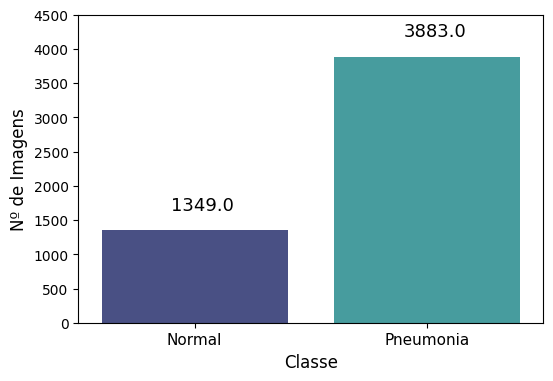

In [ ]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_train, palette="mako")

plt.xlabel("Classe", fontsize= 12)
plt.ylabel("Nº de Imagens", fontsize= 12)
plt.ylim(0,4500)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)
    
plt.show()

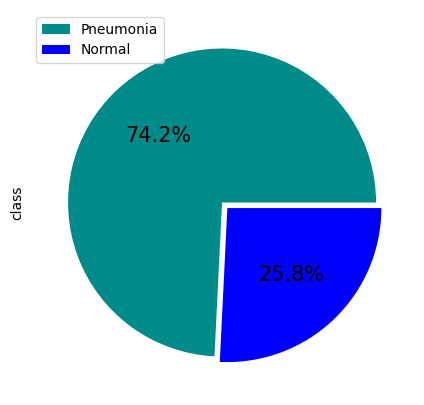

In [ ]:
plt.figure(figsize=(7,5))

df_train['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['darkcyan','blue'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.show()

**Verificando Base de Teste**

Quantidades e % de amostras por classe

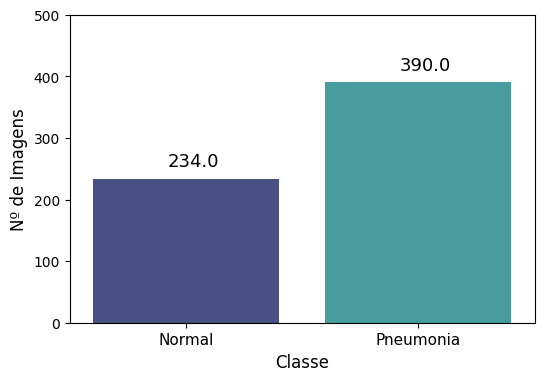

In [ ]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_test, palette="mako")

plt.xlabel("Classe", fontsize= 12)
plt.ylabel("Nº de Imagens", fontsize= 12)
plt.ylim(0,500)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.32, p.get_height()+20), fontsize = 13)
    
plt.show()

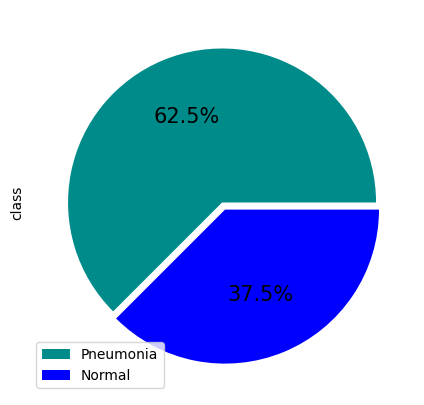

In [ ]:
plt.figure(figsize=(7,5))

df_test['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['darkcyan','blue'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.show()

**Amostra de Imagens Pacientes Saudaveis**

In [ ]:
def sampleImage(sampe_image_path):
  img = load_img(TRAIN_PATH + sampe_image_path)
  x = img_to_array(img)
  print(x.shape)
  plt.imshow(img)
  plt.axis("off")
  plt.show()

(1205, 1464, 3)


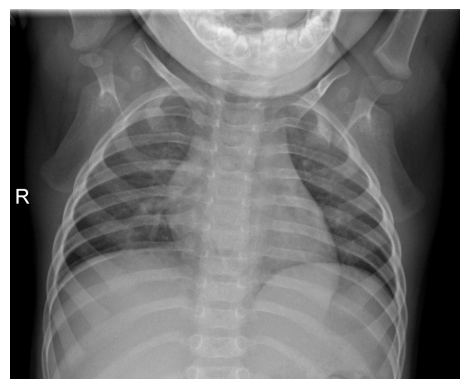

In [ ]:
sample_image_path = "/NORMAL/NORMAL-1068326-0001.jpeg"
sampleImage(sample_image_path)

**Amostra de Imagens de Pacientes com Pneumonia**

(640, 1120, 3)


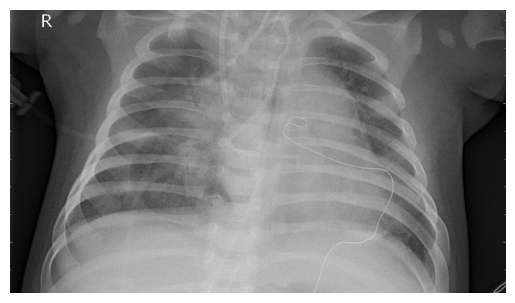

In [ ]:
sample_image_path = "/PNEUMONIA/BACTERIA-1083680-0009.jpeg"
sampleImage(sample_image_path)

# Data Augmentation

A ideia por trás do data augmentation é a introdução de variações no conjunto de dados de treinamento pode melhorar o desempenho do modelo, tornando-o mais robusto a variações nos dados de entrada. Essa técnica é útil quando o conjunto de dados de treinamento é pequeno, já que aumenta artificialmente o tamanho do conjunto de dados , reduzindo o risco de overfitting.

In [ ]:
# Data-Augmentation
ZOOM = [.99, 1.1] #Nível de zoom aplicado na imagem (Amplia ou distancia a imagem)
BRIGHT_RANGE = [0.8, 1.2] # alteração de brilho na imagem (Deixa a imagem mais clara ou mais escura)
HORZ_FLIP = True # Flip Horizontal na imagem (Ajuda a identificar pneumonia nos dois pulmões)
FILL_MODE = "constant" #Tipo de preenchimento da imagem (Bordas Pretas)
DATA_FORMAT = "channels_last"

train_datagen = IDG(validation_split=0.2,
                    rescale=1./255,
                    brightness_range=BRIGHT_RANGE,
                    zoom_range=ZOOM,
                    data_format=DATA_FORMAT,
                    fill_mode=FILL_MODE,
                    horizontal_flip=HORZ_FLIP) 
                                   
train_generator = train_datagen.flow_from_directory(directory=TRAIN_PATH, batch_size=BATCH_SIZE, class_mode='categorical', target_size=TARGET_SIZE, subset='training')

validation_generator = train_datagen.flow_from_directory(directory=TRAIN_PATH, batch_size=BATCH_SIZE, class_mode='categorical', target_size=TARGET_SIZE, subset='validation')

image_train, label_train = train_generator.next()




# Validação\Teste não deve ser aumentado.
test_datagen = IDG(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(directory=TEST_PATH, batch_size = BATCH_SIZE, class_mode='categorical', target_size=TARGET_SIZE, shuffle=True)

image_test, label_test = test_generator.next()

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Visualização do Processo de Data Augmentation

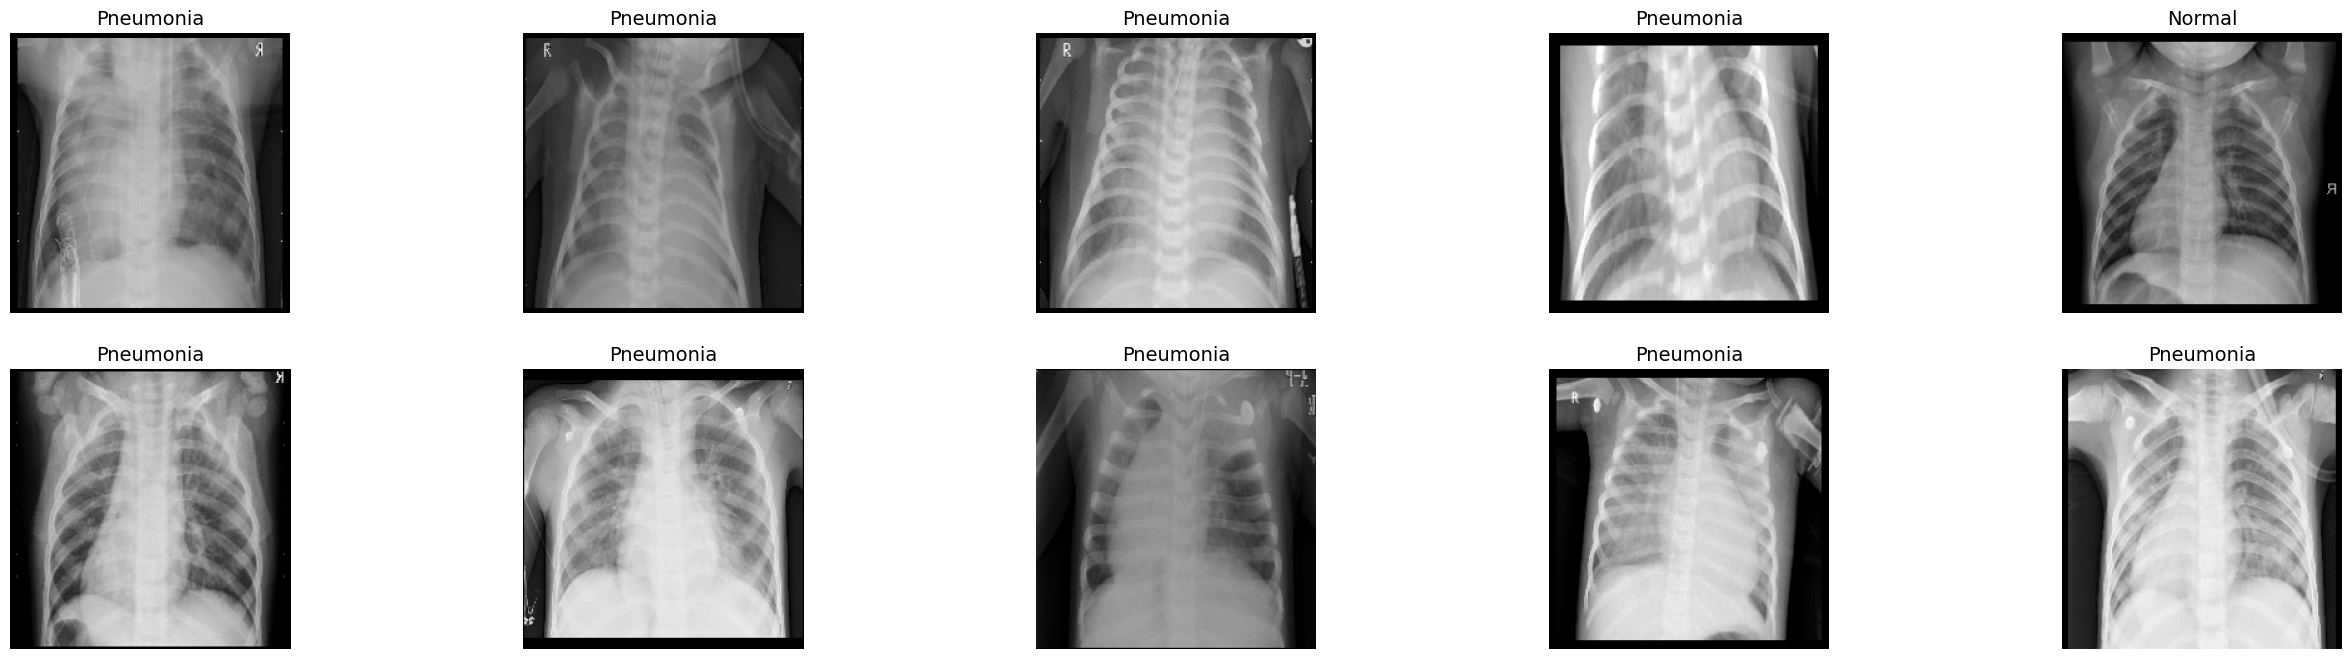

In [ ]:
def show_tarin(batch_size, images, labels):
    
    images = images[0:batch_size,:,:,:]
    labels = labels[0:batch_size,:]
    
    image_rows = 2
    image_col = int(batch_size/image_rows)
    
    _, axs = plt.subplots(image_rows, image_col, figsize=(32,8))
    axs = axs.flatten()
    
    for i in range(batch_size):
        img = images[i,:,:,:]
        lab = labels[i,:]
        axs[i].imshow(img)
        axs[i].axis('off')
        lab = np.argmax(lab)
        axs[i].set_title(label = CLASSES[lab], fontsize=14)

    plt.show()
    
    
show_tarin(10, image_train, label_train)

# Importanto Modelo Pré-Treinado

O parâmetro *weights* define que a utilização de pesos pré-treinados na base de dados ImageNet. O parâmetro *include_top* define a inclusão camadas densas finais da rede, que foram treinadas na base de dados ImageNet para realizar a classificação de imagens em mais de 1.000 categorias.

In [ ]:
DenseT = DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
from PIL import ImageFont

font = ImageFont.truetype("/content/drive/MyDrive/Colab Notebooks/DATASET/arial.ttf", 100)
visualkeras.layered_view(DenseT, legend=True, font=font)

# Adicionando Camadas ao Modelo e Travando o Aprendizado das Camadas

O transfer learning é uma técnica que consiste em utilizar conhecimentos adquiridos em um modelo treinado em uma tarefa para melhorar o desempenho de um modelo em outra tarefa relacionada. Permite reutilizar os pesos e camadas de um modelo pré-treinado em uma tarefa relacionada, e adaptar esse modelo para a nova tarefa. 

In [ ]:
for layer in DenseT.layers:
    layer.trainable=False

In [ ]:
Dense_model = DenseT.output
Dense_model = tf.keras.layers.Dropout(0.35)(Dense_model)
Dense_model = tf.keras.layers.GlobalAveragePooling2D()(Dense_model)
Dense_model = tf.keras.layers.Dropout(0.15)(Dense_model)
Dense_model = tf.keras.layers.Dense(2, kernel_initializer=GlorotNormal(),
                          activation = 'softmax', kernel_regularizer= tf.keras.regularizers.L2(0.0001),
                          bias_regularizer= tf.keras.regularizers.L2(0.0001))(Dense_model)

Dense_model = tf.keras.models.Model(inputs=DenseT.input, outputs = Dense_model)

visualkeras.layered_view(Dense_model, legend=True, font=font)

# Definição de Métricas e Callbacks

In [ ]:
METRICS = [
            tf.keras.metrics.BinaryAccuracy(name='acuracia'),
            tf.keras.metrics.Precision(name='precisão'),
            tf.keras.metrics.Recall(name='recall'),  
            tf.keras.metrics.AUC(name='auc'),
           ]

**Definição das Callbacks**

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.01 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.001, 5)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

early = EarlyStopping(monitor='auc', patience=5)

A adaptação da taxa de aprendizado permite que o algoritmo de aprendizado de máquina ajuste a taxa de aprendizado em tempo real, permitindo que ele se adapte a diferentes problemas de aprendizado e minimize a perda com mais eficiência.

O early stopping ajuda a garantir que o modelo tenha um bom desempenho não apenas nos dados de treinamento, mas também em novos dados. 

**Compilação do Modelo**

In [ ]:
Dense_model.compile(optimizer='rmsprop',
                    loss=tf.losses.CategoricalCrossentropy(),
                    metrics=METRICS)

O RMSprop ajusta a taxa de aprendizado para cada peso de acordo com a magnitude média do gradiente daquele peso ao longo do tempo.

A Categorical Cross Entropy é uma função loss contínua e diferenciável, o que a torna adequada para uso em algoritmos de otimização baseados em gradiente descendente, como o RMSprop. Ela é usada para minimizar o erro de classificação do modelo durante o treinamento, ajustando os pesos da rede neural para melhorar a precisão da classificação.

# Treinamento da Rede

In [ ]:
history = Dense_model.fit(train_generator,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=validation_generator,
                    callbacks=[lr_scheduler, early],
                    verbose=1)

print('\n*** Acabou o treinamento ***')

Epoch 1/100
131/131 [==============================] - 177s 1s/step - loss: 0.2527 - acuracia: 0.8961 - precisão: 0.8961 - recall: 0.8961 - auc: 0.9634 - val_loss: 0.1343 - val_acuracia: 0.9483 - val_precisão: 0.9483 - val_recall: 0.9483 - val_auc: 0.9908 - lr: 0.0010
Epoch 2/100
131/131 [==============================] - 141s 1s/step - loss: 0.1525 - acuracia: 0.9424 - precisão: 0.9424 - recall: 0.9424 - auc: 0.9865 - val_loss: 0.1289 - val_acuracia: 0.9474 - val_precisão: 0.9474 - val_recall: 0.9474 - val_auc: 0.9904 - lr: 3.9811e-04
Epoch 3/100
131/131 [==============================] - 155s 1s/step - loss: 0.1383 - acuracia: 0.9484 - precisão: 0.9484 - recall: 0.9484 - auc: 0.9890 - val_loss: 0.1175 - val_acuracia: 0.9531 - val_precisão: 0.9531 - val_recall: 0.9531 - val_auc: 0.9926 - lr: 1.5849e-04
Epoch 4/100
131/131 [==============================] - 142s 1s/step - loss: 0.1326 - acuracia: 0.9518 - precisão: 0.9518 - recall: 0.9518 - auc: 0.9899 - val_loss: 0.1117 - val_acuracia

Salvando o modelo treinado

In [ ]:
Dense_model.save('/content/drive/MyDrive/Colab Notebooks/Trabalho da Raquel/Dense_model.h5')

# Visualização das Métricas de Treino

Construir um gráfico com o desenvolvimento das métricas durante o processo de treinamento e validação da rede.

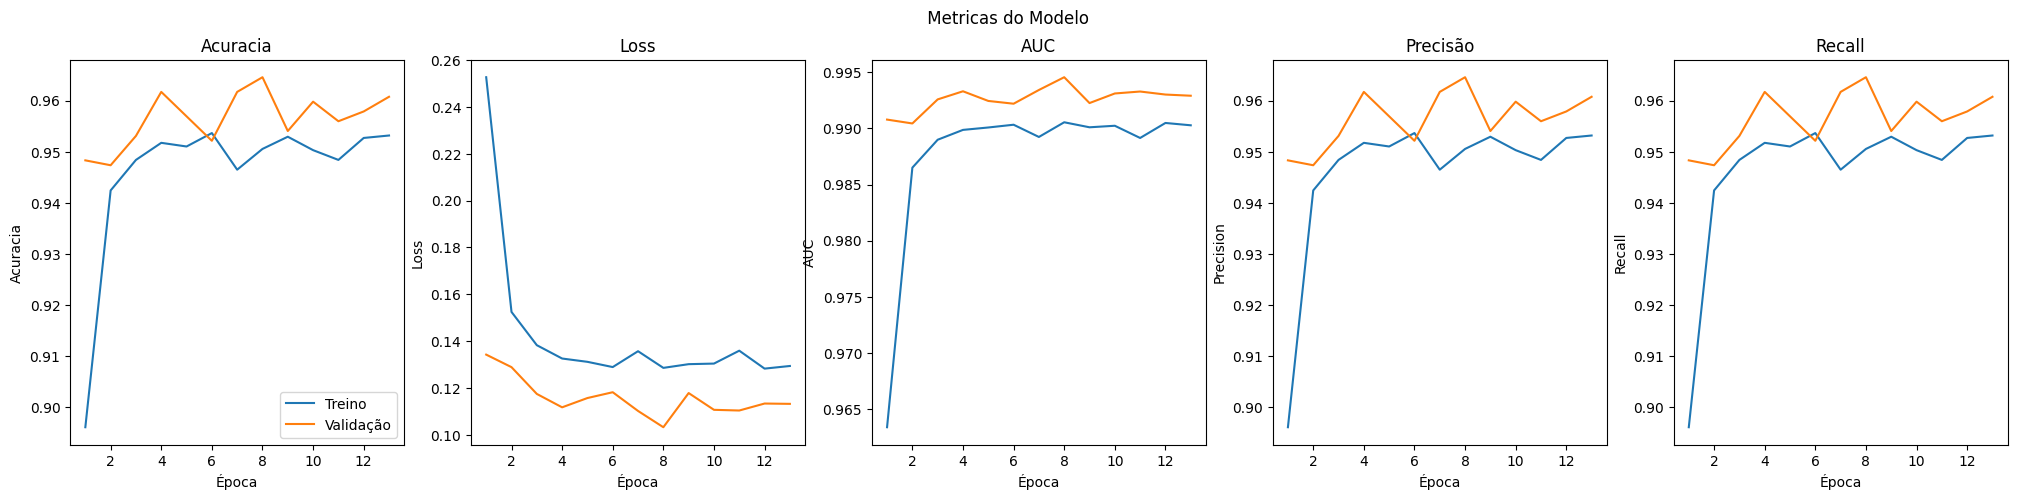

In [ ]:
#def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision, recall, val_recall):
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (25,5))
    fig.suptitle(" Metricas do Modelo ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('Acuracia')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Acuracia')
    ax1.legend(['Treino', 'Validação'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('Loss')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Loss')
    ax1.legend(['Treino', 'Validação'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('AUC')
    ax3.set_xlabel('Época')
    ax3.set_ylabel('AUC')
    ax1.legend(['Treino', 'Validação'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('Precisão')
    ax4.set_xlabel('Época')
    ax4.set_ylabel('Precision')
    ax1.legend(['Treino', 'Validação'])

    ax5.plot(range(1, len(recall) + 1), recall)
    ax5.plot(range(1, len(val_recall) + 1), val_recall)
    ax5.set_title('Recall')
    ax5.set_xlabel('Época')
    ax5.set_ylabel('Recall')
    ax1.legend(['Treino', 'Validação'])
    '''
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('F1-score')
    ax5.set_xlabel('Época')
    ax5.set_ylabel('F1 score')
    ax1.legend(['Treino', 'Validação'])
'''

    plt.show()
    

Train_Val_Plot(history.history['acuracia'],history.history['val_acuracia'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precisão'],history.history['val_precisão'],
               history.history['recall'],history.history['val_recall'],
               #history.history['f1_score'],history.history['val_f1_score']
              )

# Visualização das Métricas de Teste

In [ ]:
test_scores = Dense_model.evaluate(test_generator)

print("Acuracia = ", test_scores[1])
print("Precisão = ", test_scores[2])
print("Recall = ", test_scores[3])
print("AUC = ", test_scores[4])
#print("F1_score = ", test_scores[5])

20/20 [==============================] - 13s 651ms/step - loss: 0.2474 - acuracia: 0.8926 - precisão: 0.8926 - recall: 0.8926 - auc: 0.9629
Acuracia =  0.8926281929016113
Precisão =  0.8926281929016113
Recall =  0.8926281929016113
AUC =  0.9629061818122864


Se a acurácia durante o treinamento é significativamente maior do que a acurácia em dados de teste ou validação, é um sinal de que a rede pode estar memorizando os exemplos do conjunto de treinamento em vez de aprender os padrões gerais que se aplicam a novos dados. Isso pode levar a uma alta acurácia nos dados de treinamento, mas um desempenho inferior em novos exemplos.

# Visualização da Classificação

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Trabalho da Raquel/Dense_model.h5')

1/1 [==============================] - 5s 5s/step


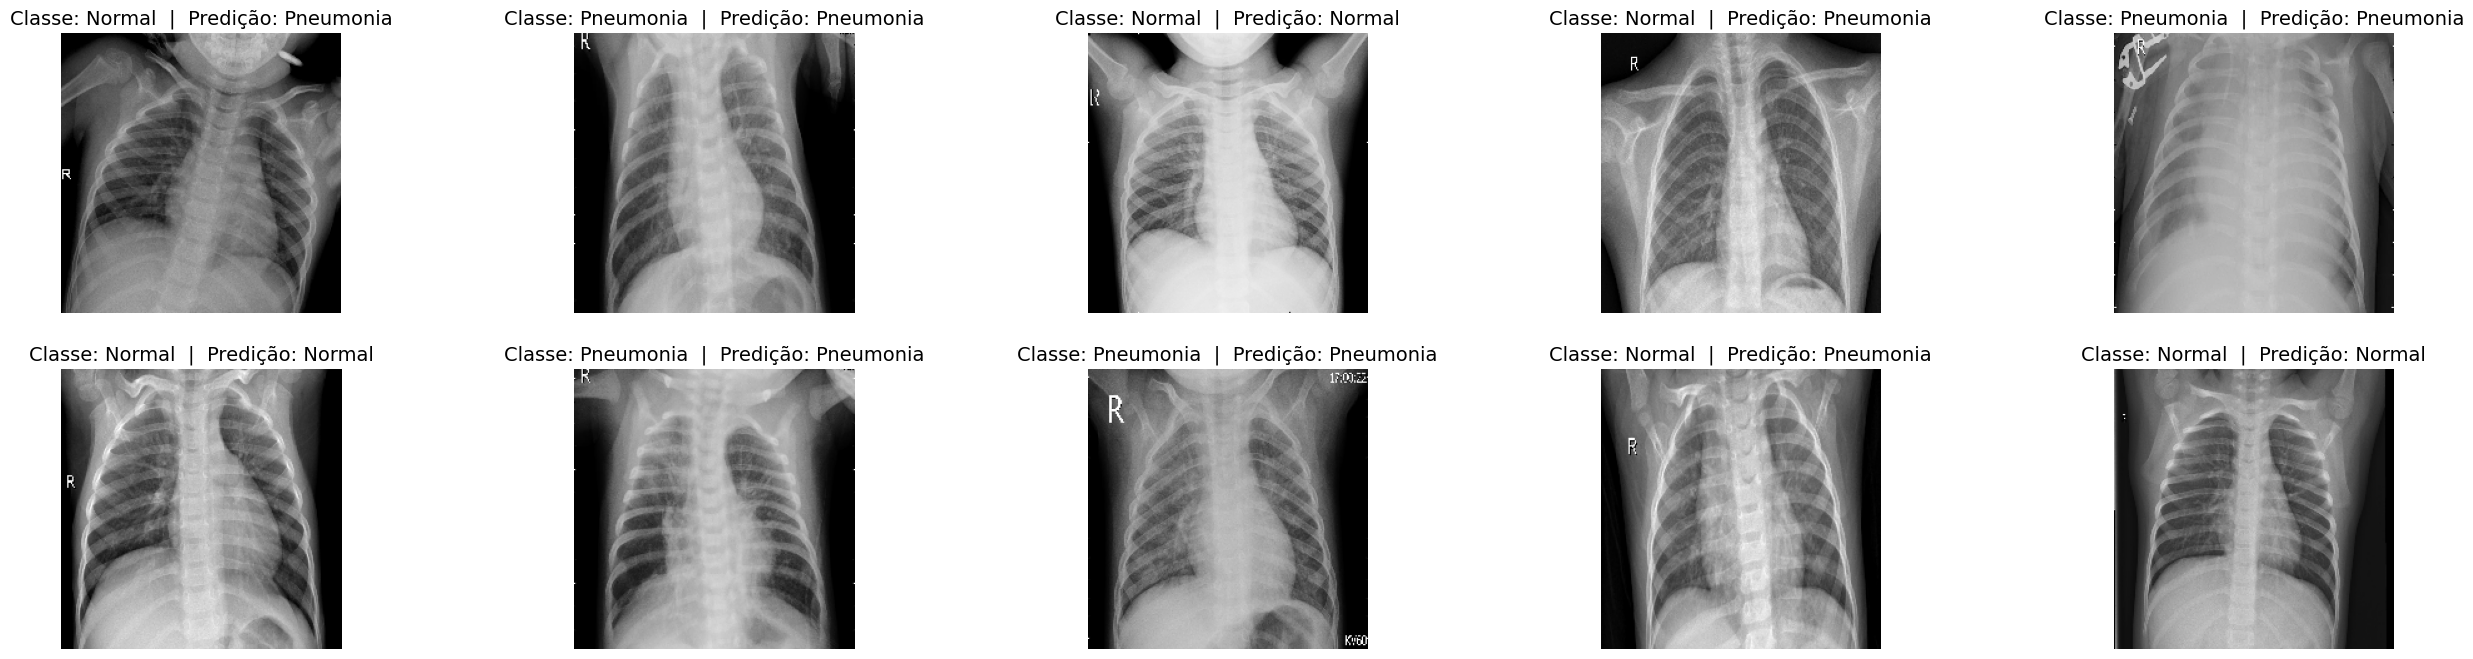

In [ ]:
def show(model, batch_size, images, labels):
    
    images = images[0:batch_size,:,:,:]
    labels = labels[0:batch_size,:]
    predict = np.round(model.predict(images))
    
    image_rows = 2
    image_col = int(batch_size/image_rows)
    
    _, axs = plt.subplots(image_rows, image_col, figsize=(32,8))
    axs = axs.flatten()
    
    for i in range(batch_size):
        img = images[i,:,:,:]
        lab = labels[i,:]
        axs[i].imshow(img)
        pred = predict[i]
        axs[i].axis('off')
        lab, pred = np.argmax(lab), np.argmax(pred)
        axs[i].set_title(label = f'Classe: {CLASSES[lab]}  |  Predição: {CLASSES[pred]}', fontsize=14)

    plt.show()
    
    
show(model, 10, image_test, label_test)

In [ ]:
def getHeatMap(image):
  single_image = cv2.imread(image)
  single_image = cv2.resize(single_image, (224, 224))
  single_image = cv2.cvtColor(single_image, cv2.COLOR_BGR2RGB)
  img = single_image/255
  img = np.asarray(img)
  img = img.reshape(1, 224, 224, 3)
  y_pred = model.predict(img)[0]
  y_pred = np.argmax(y_pred)
  classes = list({'Normal': 0, 'Pneumonia': 1})
  class_prediction = classes[y_pred]
  weights = model.layers[-1].get_weights()[0]
  weights = np.asarray(weights)
  weights = weights.reshape(weights.shape[1], weights.shape[0])
  weights_for_predicted_class_for_this_image = weights[y_pred]
  new_model = tf.keras.models.Model(
    model.input, 
    model.get_layer('conv5_block32_concat').output
    )
  output_con_layer = new_model.predict(img)[0]
  resize_image = sc.ndimage.zoom(output_con_layer, (int(224/output_con_layer.shape[0]), 
                                                  int(224/output_con_layer.shape[1]), 1))
  final_image = np.dot(
      resize_image.reshape(resize_image.shape[0]*resize_image.shape[1], resize_image.shape[2]),
      weights_for_predicted_class_for_this_image
  ).reshape(resize_image.shape[0], resize_image.shape[1])
  img_ = img.reshape(224, 224, 3)
  final_image = final_image/255
  return [img_, final_image, class_prediction]

In [ ]:
dataset_folder = '/content/drive/MyDrive/Colab Notebooks/Trabalho da Raquel/chest_xray/'

In [ ]:
datasetObject = pathlib.Path(os.path.join(dataset_folder))
images = list(datasetObject.glob("*/*/*.*"))
arr = []
for i in images[:8]:
  arr.append(getHeatMap(os.path.join(i)))

1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 4s 4s/step


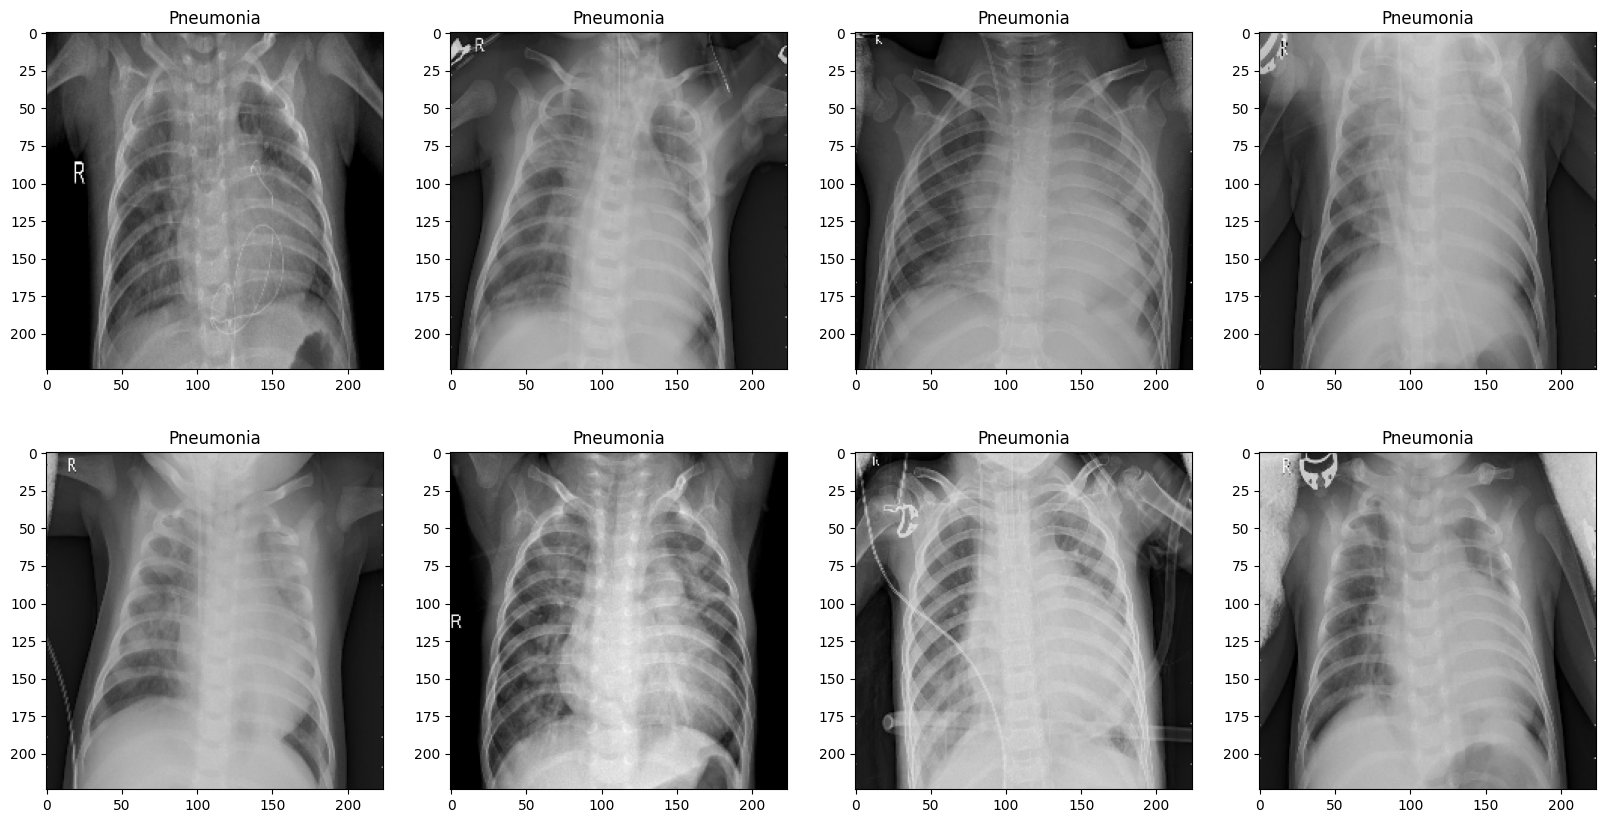

In [ ]:
plt.figure(figsize = (20, 10))
for j, i in enumerate(arr[:8]):
  plt.subplot(2, 4, j + 1)
  plt.imshow(i[0])
  plt.title(i[2])
plt.show()  

Um mapa de calor gerado por uma rede neural convolucional pode ser usado para identificar as regiões de uma imagem que a rede considerou mais importantes para tomar uma decisão sobre a classificação ou detecção de objetos. Esses mapas de calor são gerados pela rede neural convolucional, geralmente usando uma técnica chamada "camadas de ativação de mapa de características".

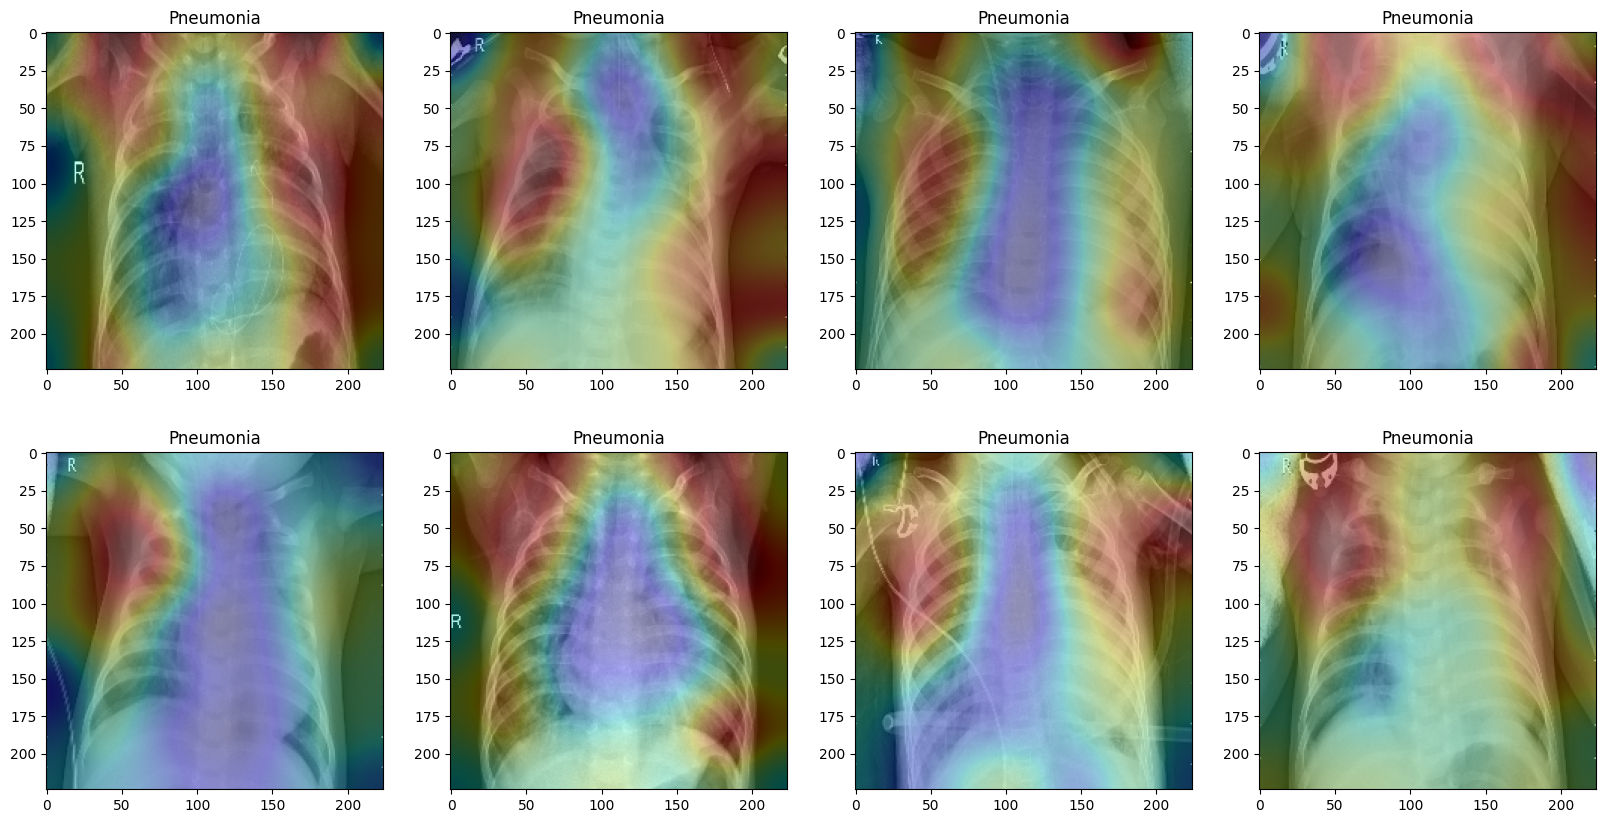

In [ ]:
plt.figure(figsize = (20, 10))
for j, i in enumerate(arr[:8]):
  plt.subplot(2, 4, j + 1)
  plt.imshow(i[0])
  plt.imshow(i[1], cmap='jet', alpha=0.3)
  plt.title(i[2])
plt.show()  

# Realizando o processo de treinamento sem Transfer Learning

In [ ]:
for layer in DenseT.layers:
    layer.trainable= True
Dense_model2 = DenseT.output
Dense_model2 = tf.keras.layers.Dropout(0.35)(Dense_model2)
Dense_model2 = tf.keras.layers.GlobalAveragePooling2D()(Dense_model2)
Dense_model2 = tf.keras.layers.Dropout(0.15)(Dense_model2)
Dense_model2 = tf.keras.layers.Dense(2, kernel_initializer=GlorotNormal(),
                          activation = 'softmax', kernel_regularizer= tf.keras.regularizers.L2(0.0001),
                          bias_regularizer= tf.keras.regularizers.L2(0.0001))(Dense_model2)

Dense_model2 = tf.keras.models.Model(inputs=DenseT.input, outputs = Dense_model2)
Dense_model2.compile(optimizer='rmsprop',
                    loss=tf.losses.CategoricalCrossentropy(),
                    metrics=METRICS)

In [ ]:
history = Dense_model2.fit(train_generator,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=validation_generator,
                    callbacks=[lr_scheduler, early],
                    verbose=1)

print('\n*** Acabou o treinamento ***')
Dense_model2.save('/content/drive/MyDrive/Colab Notebooks/Trabalho da Raquel/Dense_model_2.h5')

Epoch 1/100
131/131 [==============================] - 281s 1s/step - loss: 0.2537 - acuracia: 0.9135 - precisão: 0.9135 - recall: 0.9135 - auc: 0.9654 - val_loss: 1.9218 - val_acuracia: 0.7703 - val_precisão: 0.7703 - val_recall: 0.7703 - val_auc: 0.8165 - lr: 0.0010
Epoch 2/100
131/131 [==============================] - 164s 1s/step - loss: 0.0885 - acuracia: 0.9656 - precisão: 0.9656 - recall: 0.9656 - auc: 0.9951 - val_loss: 0.7538 - val_acuracia: 0.8134 - val_precisão: 0.8134 - val_recall: 0.8134 - val_auc: 0.9125 - lr: 3.9811e-04
Epoch 3/100
131/131 [==============================] - 180s 1s/step - loss: 0.0622 - acuracia: 0.9749 - precisão: 0.9749 - recall: 0.9749 - auc: 0.9975 - val_loss: 0.0325 - val_acuracia: 0.9895 - val_precisão: 0.9895 - val_recall: 0.9895 - val_auc: 0.9992 - lr: 1.5849e-04
Epoch 4/100
131/131 [==============================] - 163s 1s/step - loss: 0.0413 - acuracia: 0.9845 - precisão: 0.9845 - recall: 0.9845 - auc: 0.9986 - val_loss: 0.0388 - val_acuracia

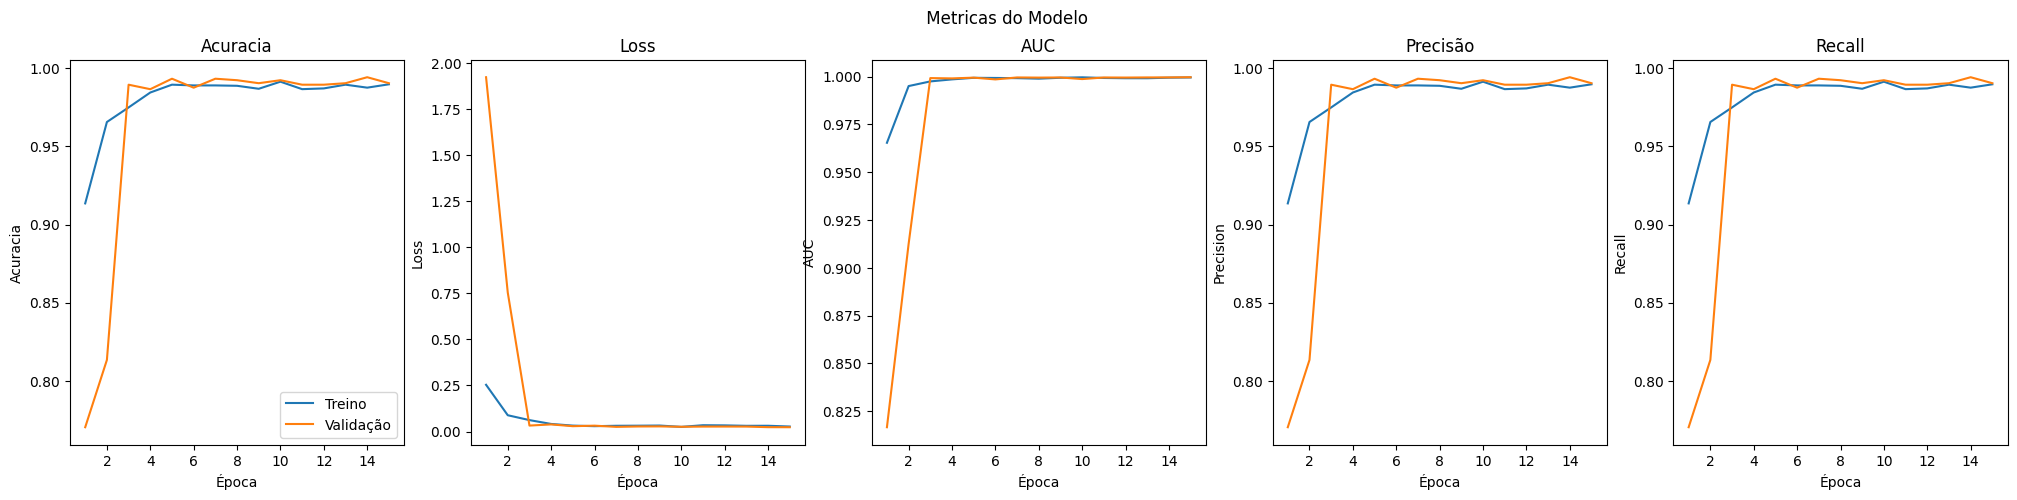

In [ ]:
Train_Val_Plot(history.history['acuracia'],history.history['val_acuracia'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precisão'],history.history['val_precisão'],
               history.history['recall'],history.history['val_recall'],
               #history.history['f1_score'],history.history['val_f1_score']
              )

In [ ]:
test_scores = Dense_model2.evaluate(test_generator)

print("Acuracia = ", test_scores[1])
print("Precisão = ", test_scores[2])
print("Recall = ", test_scores[3])
print("AUC = ", test_scores[4])

20/20 [==============================] - 10s 498ms/step - loss: 0.1558 - acuracia: 0.9567 - precisão: 0.9567 - recall: 0.9567 - auc: 0.9852
Acuracia =  0.9567307829856873
Precisão =  0.9567307829856873
Recall =  0.9567307829856873
AUC =  0.9851762056350708


A loss de 0.1558 indica a magnitude média do erro da rede durante o treinamento. Quanto menor o valor da loss, melhor é o desempenho da rede em minimizar o erro. O valor obtido pela rede sugere que a rede está tendo um bom desempenho em minimizar a função de perda durante o treinamento.

A acurácia de 0.9567 indica que a rede está correta em 95,67% das classificações realizadas nas imagens de Raio-x presentes na base de dados. Quanto maior a acurácia, melhor é o desempenho geral da rede.

A precisão de 0.9567 representa a proporção de verdadeiros positivos em relação a todos os exemplos classificados como positivos. Isso indica que a rede possui uma alta taxa de precisão nas previsões positivas.

O recall de 0.9567 indica a proporção de verdadeiros positivos em relação a todos os exemplos positivos. Isso sugere um bom desempenho da rede na identificação correta de casos positivos.

A AUC de 0.9852 avalia a habilidade da rede em distinguir entre casos positivos e negativos, independentemente do ponto de corte escolhido para a classificação. Quanto maior a AUC, melhor é a capacidade da rede em fazer essa distinção. Nesse caso, uma AUC de 0.9852 indica um desempenho muito bom na tarefa de classificação de pneumonia.

Em resumo, os resultados indicam que a rede neural convolucional apresentou um desempenho muito bom, com alta acurácia, precisão e recall, além de uma excelente capacidade de distinguir entre casos positivos e negativos. Isso sugere que a rede foi capaz de identificar corretamente tanto os casos de pneumonia quanto os casos saudáveis nas imagens de Raio-x.


In [ ]:
model2 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Trabalho da Raquel/Dense_model_2.h5')

1/1 [==============================] - 3s 3s/step


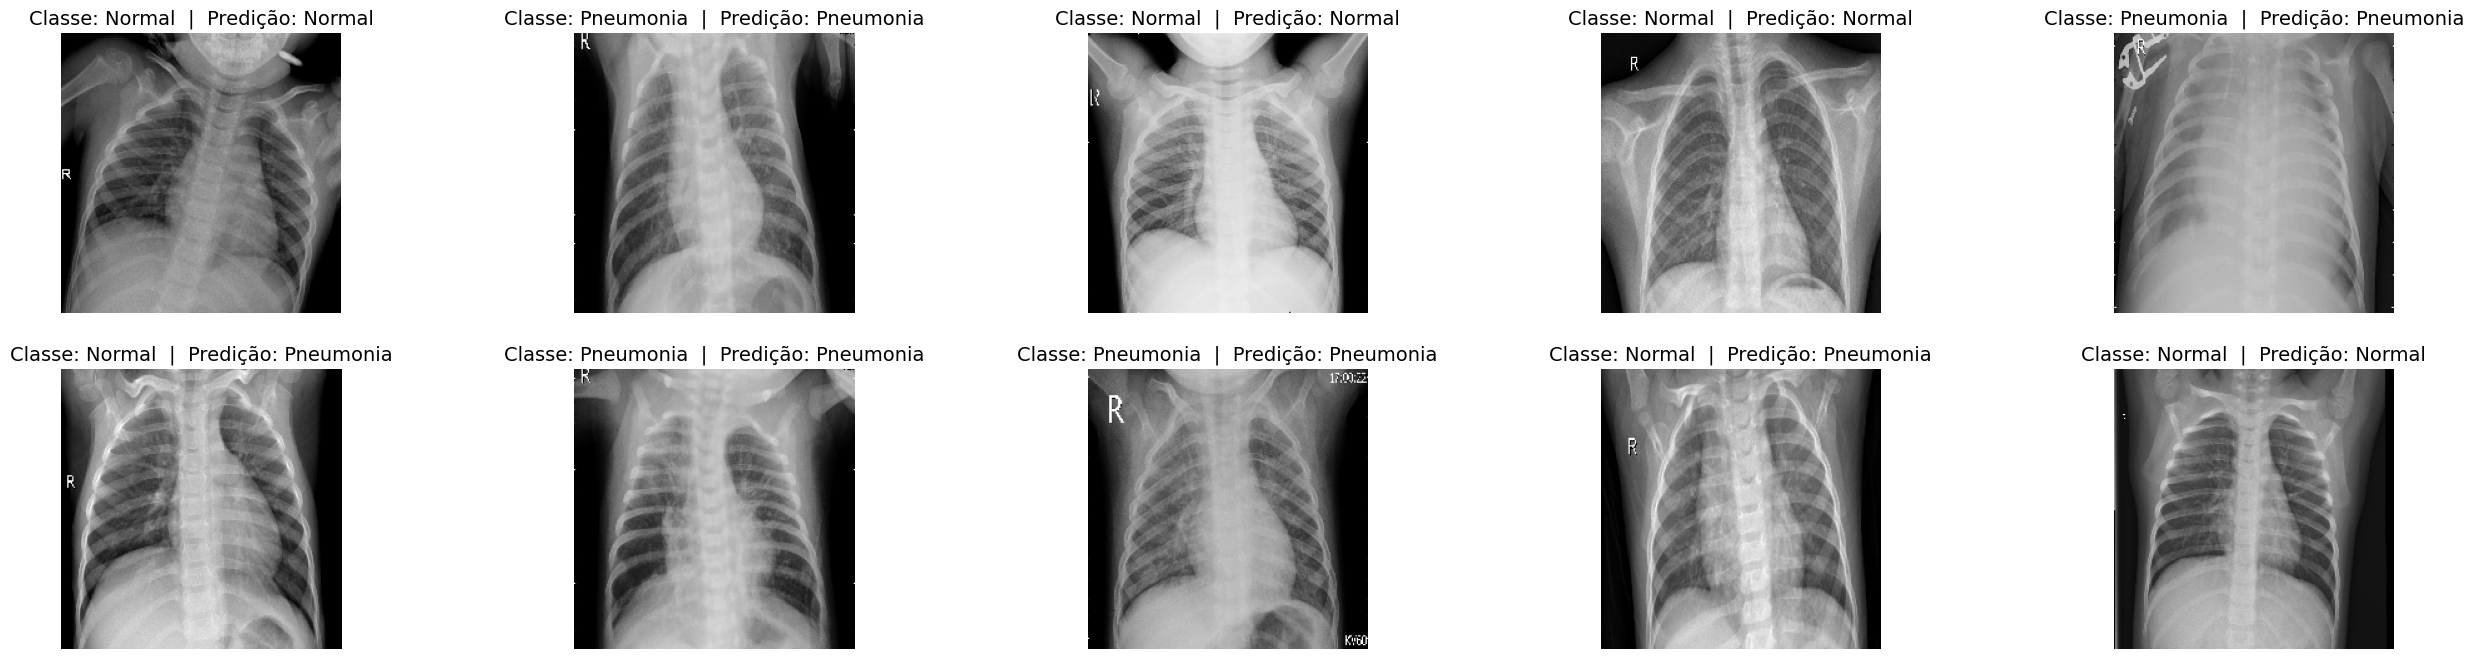

In [ ]:
show(model2, 10, image_test, label_test)

In [ ]:
def getHeatMap2(image):
  single_image = cv2.imread(image)
  single_image = cv2.resize(single_image, (224, 224))
  single_image = cv2.cvtColor(single_image, cv2.COLOR_BGR2RGB)
  img = single_image/255
  img = np.asarray(img)
  img = img.reshape(1, 224, 224, 3)
  y_pred = model.predict(img)[0]
  y_pred = np.argmax(y_pred)
  classes = list({'Normal': 0, 'Pneumonia': 1})
  class_prediction = classes[y_pred]
  weights = model.layers[-1].get_weights()[0]
  weights = np.asarray(weights)
  weights = weights.reshape(weights.shape[1], weights.shape[0])
  weights_for_predicted_class_for_this_image = weights[y_pred]
  new_model = tf.keras.models.Model(
    model.input, 
    model.get_layer('conv5_block32_concat').output
    )
  output_con_layer = new_model.predict(img)[0]
  resize_image = sc.ndimage.zoom(output_con_layer, (int(224/output_con_layer.shape[0]), 
                                                  int(224/output_con_layer.shape[1]), 1))
  final_image = np.dot(
      resize_image.reshape(resize_image.shape[0]*resize_image.shape[1], resize_image.shape[2]),
      weights_for_predicted_class_for_this_image
  ).reshape(resize_image.shape[0], resize_image.shape[1])
  img_ = img.reshape(224, 224, 3)
  final_image = final_image/255
  return [img_, final_image, class_prediction]

In [ ]:
datasetObject = pathlib.Path(os.path.join(dataset_folder))
images = list(datasetObject.glob("*/*/*.*"))
arr = []
for i in images[:8]:
  arr.append(getHeatMap2(os.path.join(i)))

1/1 [==============================] - 4s 4s/step


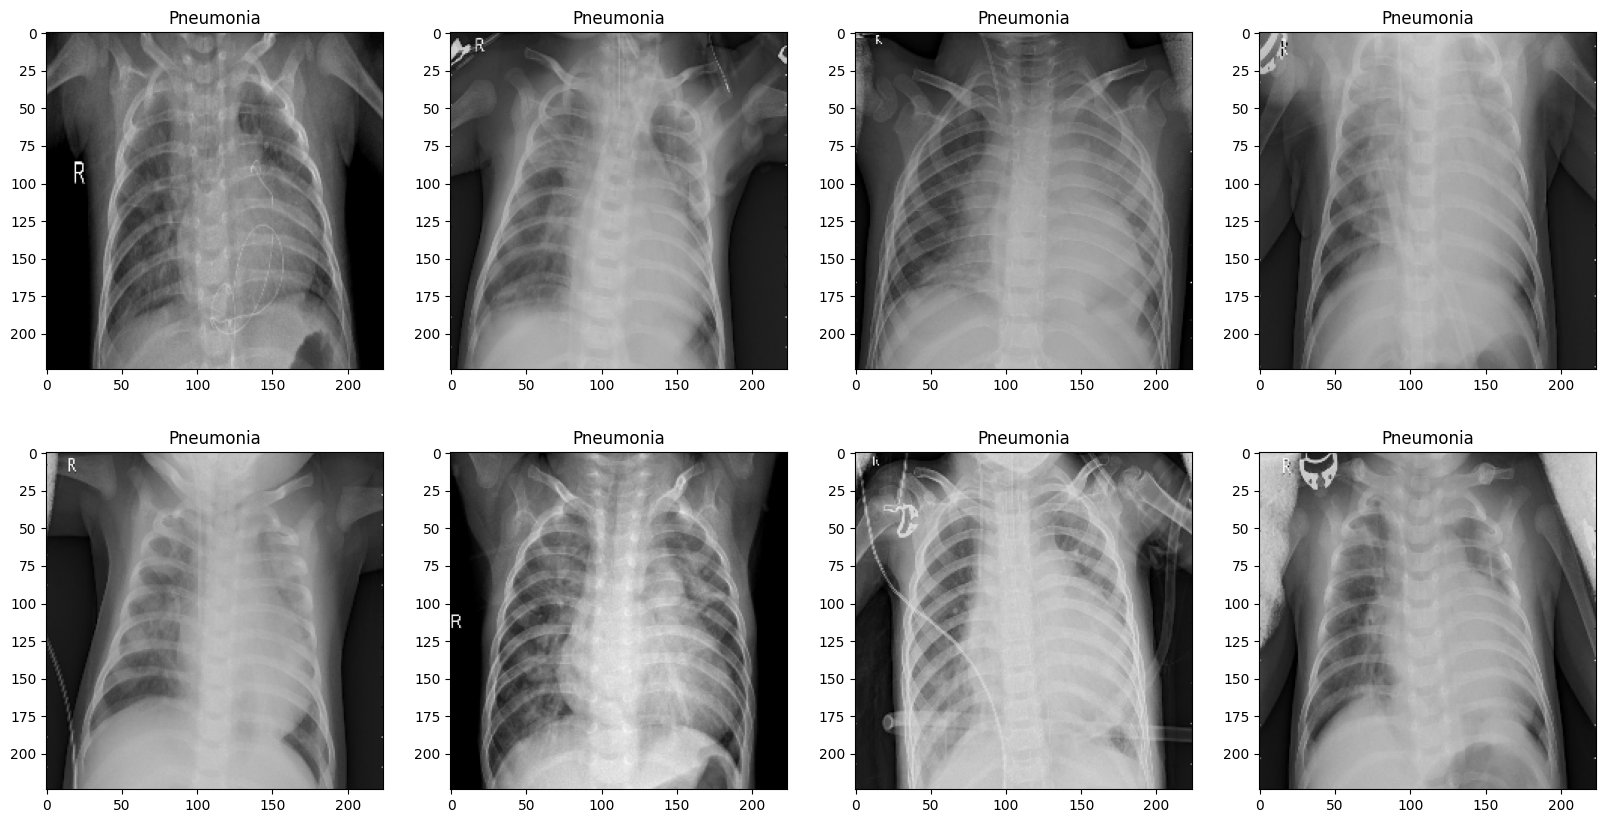

In [ ]:
plt.figure(figsize = (20, 10))
for j, i in enumerate(arr[:8]):
  plt.subplot(2, 4, j + 1)
  plt.imshow(i[0])
  plt.title(i[2])
plt.show()  

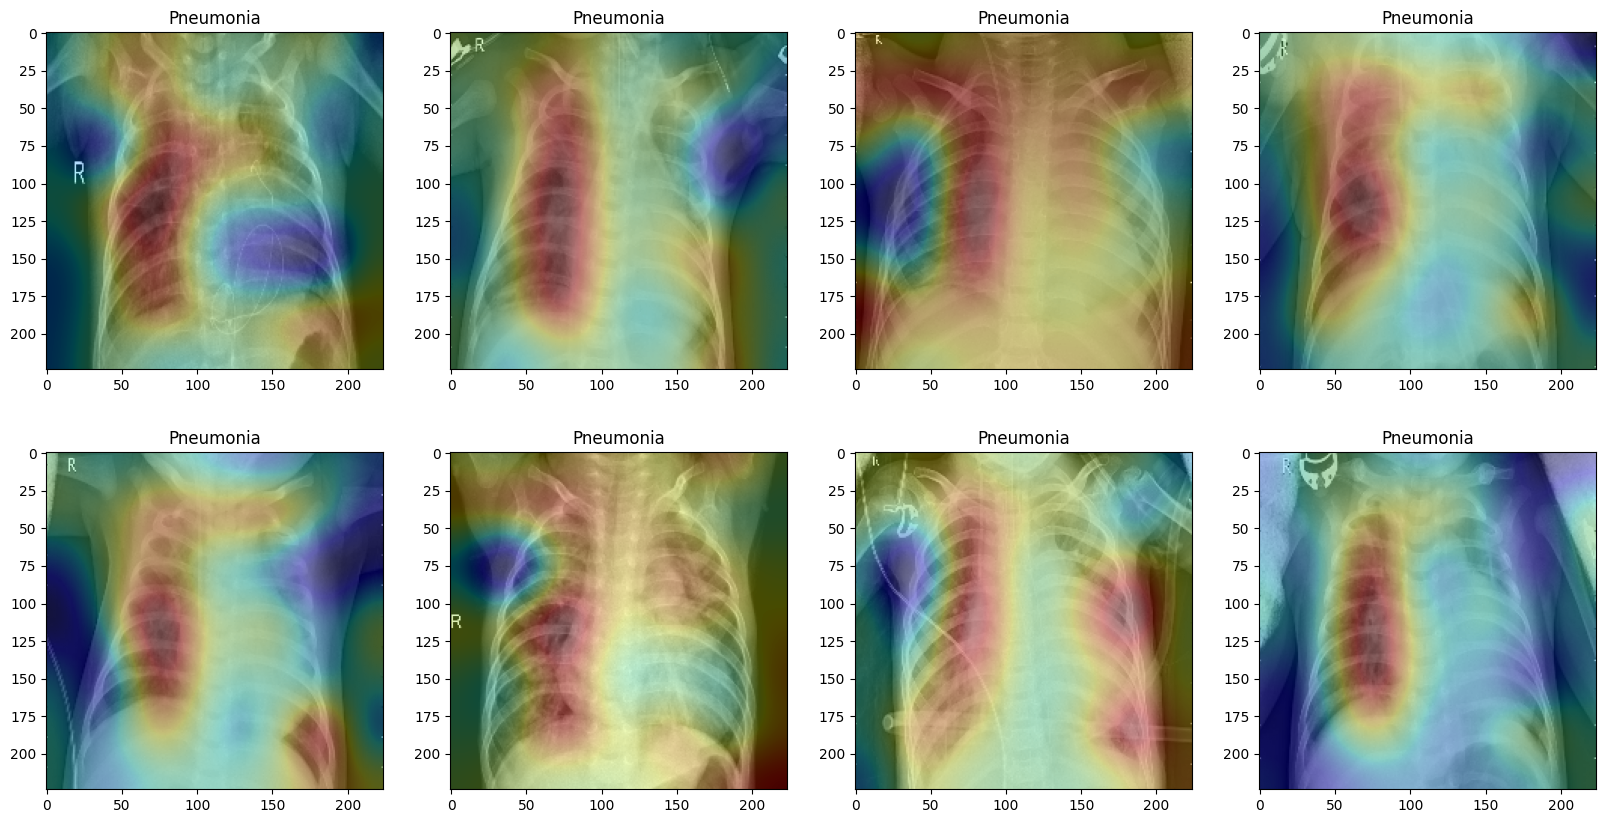

In [ ]:
plt.figure(figsize = (20, 10))
for j, i in enumerate(arr[:8]):
  plt.subplot(2, 4, j + 1)
  plt.imshow(i[0])
  plt.imshow(i[1], cmap='jet', alpha=0.3)
  plt.title(i[2])
plt.show()  